In [1027]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1028]:
# Carga de archivos

df_clientes = pd.read_csv(r"data/clean/clientes.csv")
df_productos = pd.read_csv(r"data/clean/productos.csv")
df_ventas = pd.read_csv(r"data/clean/ventas.csv")
df_detalle = pd.read_csv(r"data/clean/detalle_ventas.csv")


In [1029]:
# Parsear fechas
df_ventas['fecha'] = pd.to_datetime(df_ventas['fecha'])
df_clientes['fecha_alta'] = pd.to_datetime(df_clientes['fecha_alta'])

# Fecha de referencia (última fecha en datos)
FECHA_REF = df_ventas['fecha'].max()
print(f"Fecha maxima: {FECHA_REF}")
print(f"Total clientes: {len(df_clientes)}")
print(f"Total ventas: {len(df_ventas)}")
print(f"Total productos: {len(df_productos)}")
print(f"Total líneas detalle: {len(df_detalle)}")

Fecha maxima: 2024-10-31 22:47:00
Total clientes: 1531
Total ventas: 113751
Total productos: 100
Total líneas detalle: 280359


In [1030]:
# Join detalle con productos para categorías
df_full = df_detalle.merge(
    df_productos[['id_producto', 'categoria']], 
    on='id_producto',
    how='left'
)

# Join con ventas para fechas
df_full = df_full.merge(
    df_ventas[['id_venta', 'id_cliente', 'fecha']], 
    on='id_venta',
    how='left'
)

print(f"Dataset completo: {len(df_full)} registros")

Dataset completo: 280359 registros


#### Feature Engineering

In [1031]:
# 1. FEATURES RFM

# Recency: días desde última compra
recency = df_full.groupby('id_cliente')['fecha'].max().reset_index()
recency['recency_dias'] = (FECHA_REF - recency['fecha']).dt.days
recency = recency[['id_cliente', 'recency_dias']]

# Frequency: número de compras únicas
frequency = df_ventas.groupby('id_cliente')['id_venta'].nunique().reset_index()
frequency.columns = ['id_cliente', 'frequency']

# # Monetary: gasto total
monetary = df_full.groupby('id_cliente')['importe'].sum().reset_index()
monetary.columns = ['id_cliente', 'monetary']

# Combinar RFM
features = recency.merge(frequency, on='id_cliente')
features = features.merge(monetary, on='id_cliente')

In [1032]:
# 2. FEATURES DE COMPORTAMIENTO POR CATEGORÍA

# Gasto por cliente y categoría
gasto_categoria = df_full.groupby(['id_cliente', 'categoria'])['importe'].sum().reset_index()

# Pivot: categorías como columnas
gasto_pivot = gasto_categoria.pivot(
    index='id_cliente', 
    columns='categoria', 
    values='importe'
).fillna(0)

# Renombrar columnas
gasto_pivot.columns = [f'gasto_{col.lower().replace(" ", "_").replace("y", "").replace("__", "_")}' 
                       for col in gasto_pivot.columns]

# Calcular PORCENTAJES (más importante que valores absolutos)
gasto_total = gasto_pivot.sum(axis=1)
gasto_pct = gasto_pivot.div(gasto_total, axis=0) * 100
gasto_pct.columns = [col.replace('gasto_', 'pct_') for col in gasto_pct.columns]

# Merge con features
features = features.merge(gasto_pct, left_on='id_cliente', right_index=True, how='left')

In [1033]:
# 3. FEATURES DE DIVERSIDAD
categoria_cols = [col for col in features.columns if col.startswith('pct_')]

# Diversidad de categorías (Shannon entropy)
def shannon_entropy(row):
    """Calcula entropía de Shannon para diversidad de categorías"""
    from scipy.stats import entropy
    probs = row[categoria_cols].values
    probs = probs[probs > 0]
    return entropy(probs)

features['diversidad_categorias'] = features.apply(shannon_entropy, axis=1)

In [1034]:

# 3. FEATURES DE DIVERSIDAD
# Productos únicos comprados
productos_unicos = df_full.groupby('id_cliente')['id_producto'].nunique().reset_index()
productos_unicos.columns = ['id_cliente', 'productos_unicos']

# Productos por transacción (promedio)
productos_por_tx = df_full.groupby(['id_cliente', 'id_venta'])['id_producto'].count().reset_index()
productos_por_tx = productos_por_tx.groupby('id_cliente')['id_producto'].mean().reset_index()
productos_por_tx.columns = ['id_cliente', 'productos_por_transaccion']

# Merge
features = features.merge(productos_unicos, on='id_cliente', how='left')
features = features.merge(productos_por_tx, on='id_cliente', how='left')

# 5. FEATURES TEMPORALES
# Días promedio entre compras
fechas_por_cliente = df_full.groupby('id_cliente')['fecha'].unique().reset_index()

def calcular_dias_entre_compras(fechas):
    """Calcula promedio de días entre compras"""
    if len(fechas) <= 1:
        return 0
    fechas_sorted = sorted(fechas)
    diferencias = np.diff(fechas_sorted).astype('timedelta64[D]').astype(int)
    return np.mean(diferencias)

fechas_por_cliente['dias_entre_compras'] = fechas_por_cliente['fecha'].apply(
    calcular_dias_entre_compras
)
fechas_por_cliente = fechas_por_cliente[['id_cliente', 'dias_entre_compras']]

# Merge
features = features.merge(fechas_por_cliente, on='id_cliente', how='left')

In [1035]:
# DEFINIR FEATURE SETS PARA CLUSTERING

# Excluir id_cliente
X_all = features.drop('id_cliente', axis=1)

In [1036]:
X_all.columns

Index(['recency_dias', 'frequency', 'monetary', 'pct_bebidas',
       'pct_bebidas_alcohólicas', 'pct_congelados', 'pct_despensa',
       'pct_limpieza_cuidado', 'pct_lácteos_panadería', 'pct_snacks_golosinas',
       'diversidad_categorias', 'productos_unicos',
       'productos_por_transaccion', 'dias_entre_compras'],
      dtype='object')

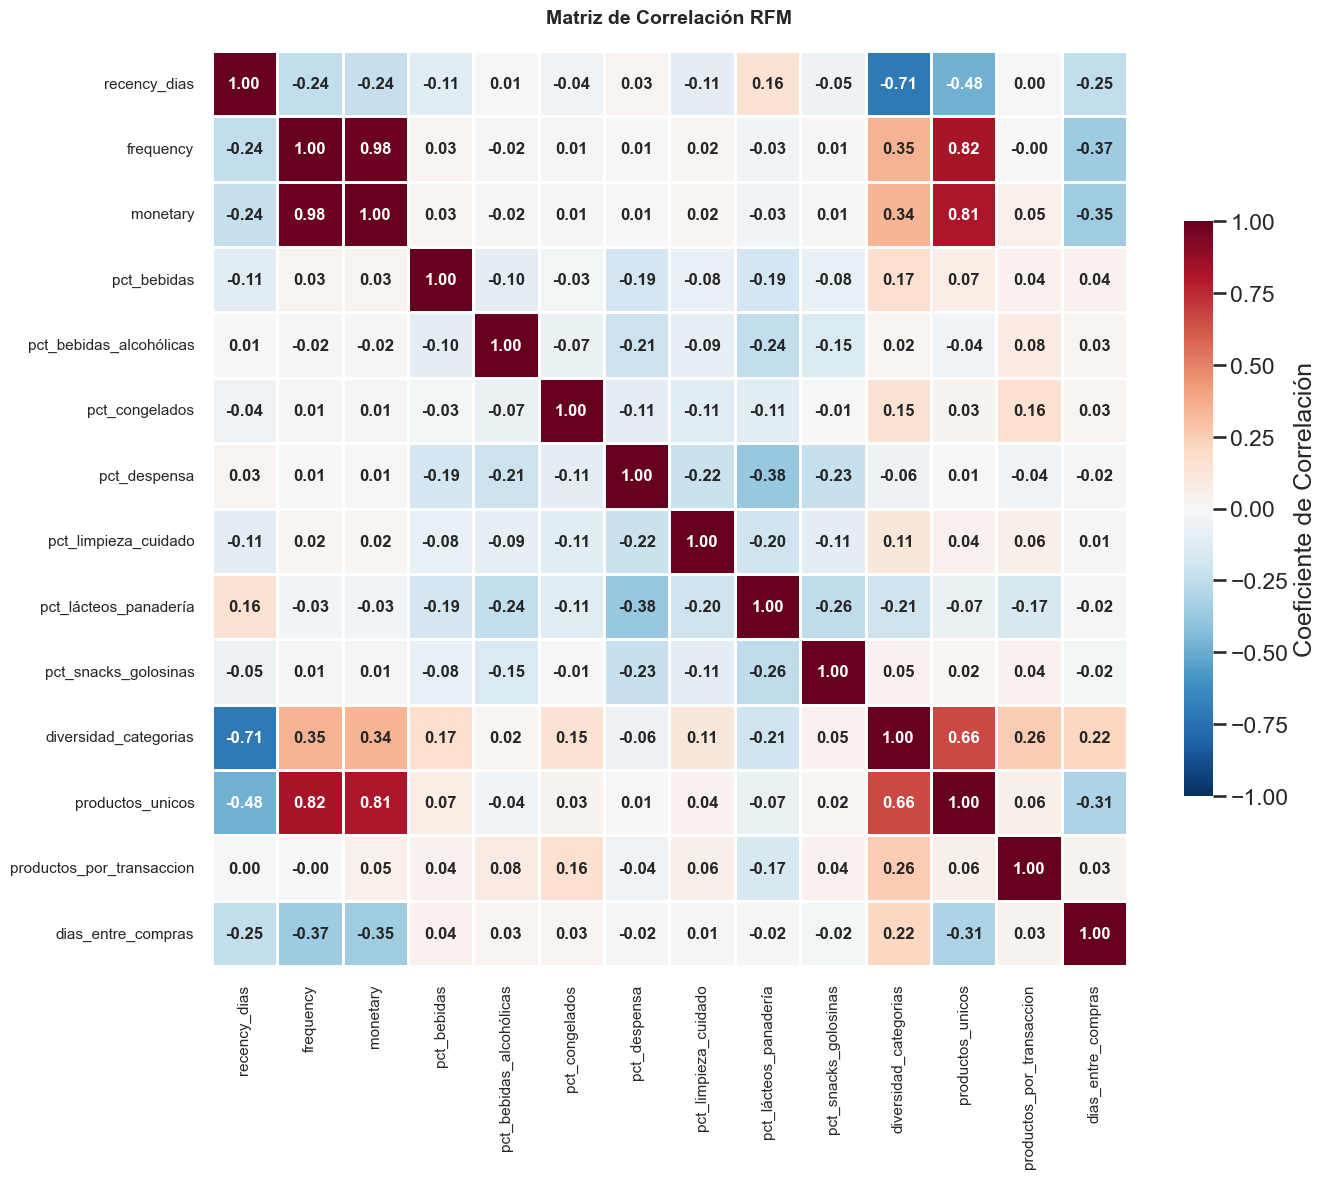

In [1037]:
corr_matrix = X_all.corr()

# Visualización
fig, ax = plt.subplots(figsize=(14, 12))

# Visualizar la matriz con un mapa de calor más compacto
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt=".2f",
            linewidths=1, vmin=-1, vmax=1, square=True,
            cbar_kws={'shrink': 0.6, 'label': 'Coeficiente de Correlación'},
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})

plt.title('Matriz de Correlación RFM', fontsize=14, fontweight='bold', pad=20)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

In [1038]:

# Identificar correlaciones altas
print("\n🔍 Features con correlación alta (|r| > 0.5):")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'feature_1': corr_matrix.columns[i],
                'feature_2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

if high_corr:
    df_high_corr = pd.DataFrame(high_corr).sort_values('correlation', 
                                                        key=abs, 
                                                        ascending=False)
    print(df_high_corr.to_string(index=False))
else:
    print("   ✓ No hay correlaciones altas detectadas")



🔍 Features con correlación alta (|r| > 0.5):
   feature_1             feature_2  correlation
   frequency              monetary     0.979875
   frequency      productos_unicos     0.822585
    monetary      productos_unicos     0.814386
recency_dias diversidad_categorias    -0.713674


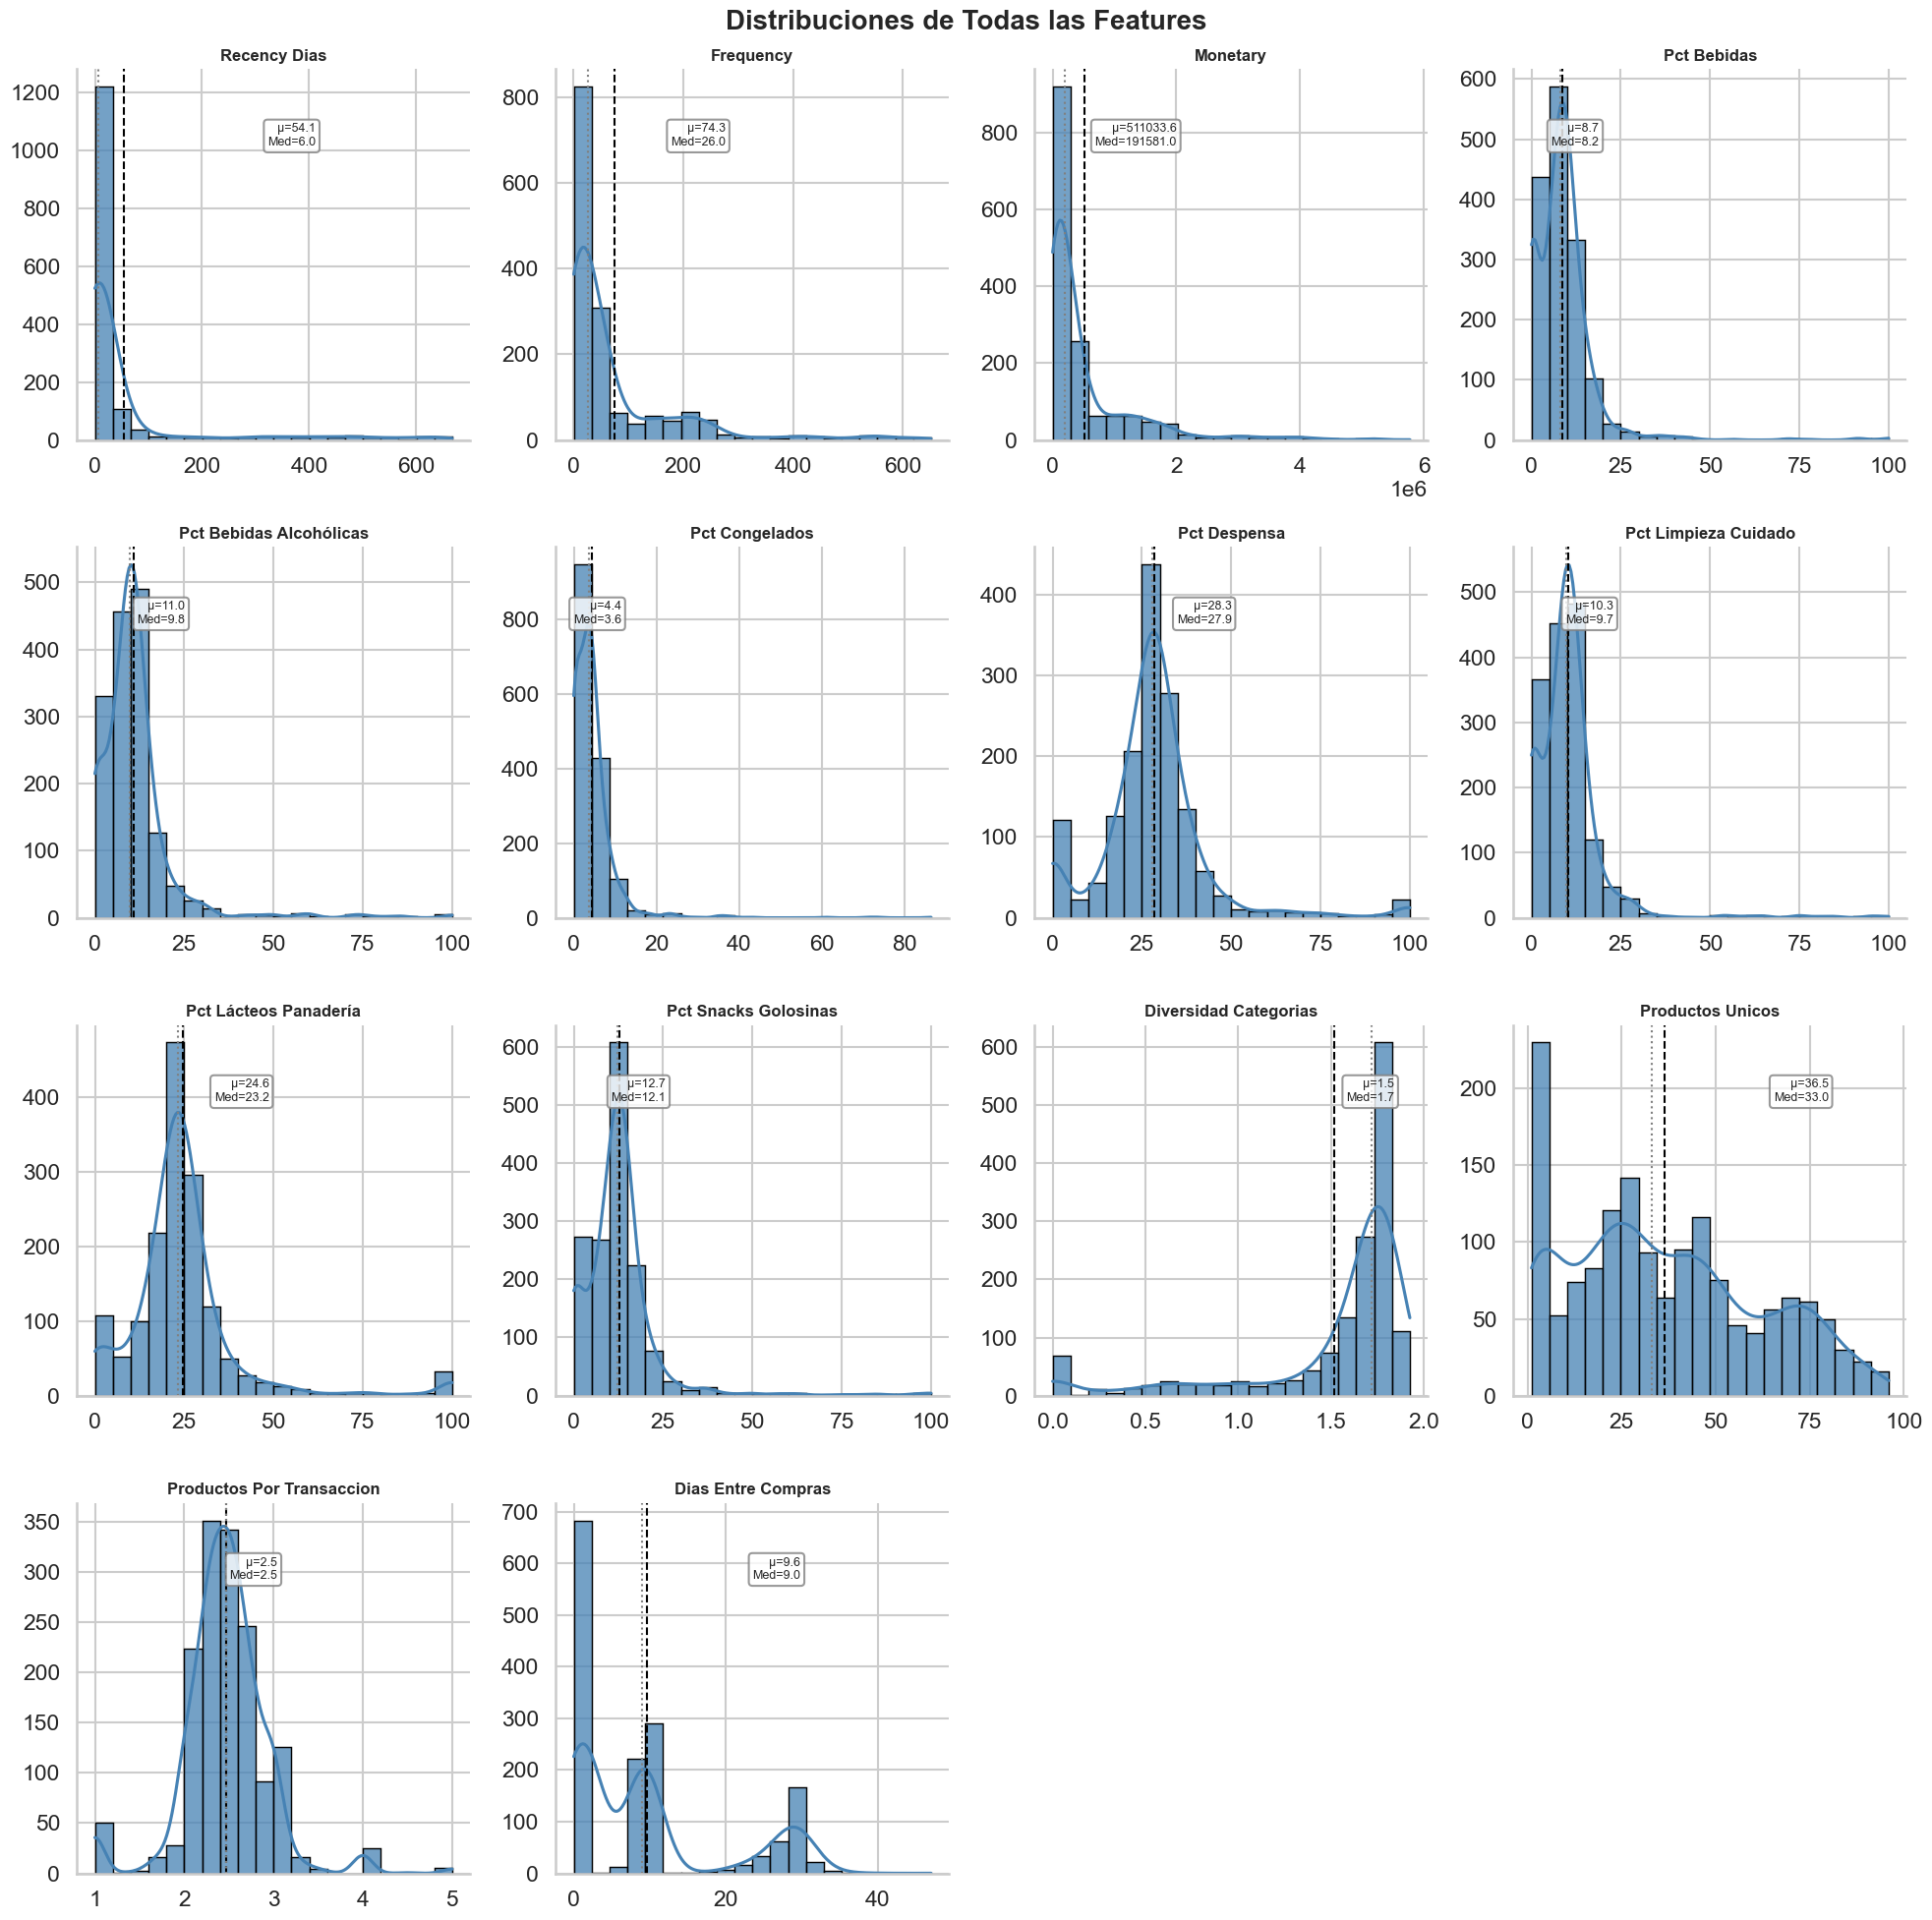

In [1039]:
sns.set_style("whitegrid")
sns.set_context("talk")

# Crear una grilla más grande para acomodar 14 features
n_features = len(X_all.columns)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols  # Redondear hacia arriba

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
fig.suptitle('Distribuciones de Todas las Features', fontsize=20, weight='bold')
fig.subplots_adjust(top=0.95, wspace=0.3, hspace=0.4)

# Aplanar axes para facilitar iteración
axes = axes.flatten()

# Helper para dibujar media/mediana
def _annotate_stats(ax, data, xpos='right'):
    mean = data.mean()
    median = data.median()
    ymax = ax.get_ylim()[1]
    ax.axvline(mean, color='k', linestyle='--', linewidth=1.5)
    ax.axvline(median, color='gray', linestyle=':', linewidth=1.5)
    
    # Posición del texto
    x_text = data.quantile(0.95) if xpos == 'right' else data.quantile(0.05)
    ax.text(x_text, ymax*0.82, f"μ={mean:.1f}\nMed={median:.1f}", 
            ha='right' if xpos == 'right' else 'left', va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8), 
            fontsize=9)

# Crear histogramas para cada feature
for idx, col in enumerate(X_all.columns):
    ax = axes[idx]
    
    # Histograma
    sns.histplot(X_all[col], bins=20, kde=True, 
                color='steelblue', alpha=0.75, edgecolor='k', ax=ax)
    
    # Títulos y etiquetas
    ax.set_title(col.replace('_', ' ').title(), fontsize=12, weight='semibold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Estadísticas
    _annotate_stats(ax, X_all[col])
    sns.despine(ax=ax)

# Ocultar ejes sobrantes si los hay
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

In [1040]:
stats = pd.DataFrame({
    'feature': X_all.columns,
    'skewness': X_all.skew(),
    'kurtosis': X_all.kurtosis(),
    'min': X_all.min(),
    'max': X_all.max(),
    'zeros_%': (X_all == 0).sum() / len(X_all) * 100
}).round(3)

print(stats.to_string(index=False))

                  feature  skewness  kurtosis   min         max  zeros_%
             recency_dias     3.110     8.876   0.0     667.000   12.802
                frequency     2.624     7.543   1.0     651.000    0.000
                 monetary     2.839     9.545 272.0 5774189.000    0.000
              pct_bebidas     4.756    38.411   0.0     100.000   18.877
  pct_bebidas_alcohólicas     4.034    23.449   0.0     100.000   12.998
           pct_congelados     6.202    63.600   0.0      86.470   18.746
             pct_despensa     1.597     6.425   0.0     100.000    7.511
     pct_limpieza_cuidado     4.242    27.698   0.0     100.000   16.003
    pct_lácteos_panadería     2.494     9.590   0.0     100.000    4.833
     pct_snacks_golosinas     3.828    22.948   0.0     100.000   12.541
    diversidad_categorias    -2.039     3.183   0.0       1.924    4.442
         productos_unicos     0.385    -0.839   1.0      96.000    0.000
productos_por_transaccion     0.297     5.076   1.0

In [1041]:
import pandas as pd

# Calcular outliers con regla 1.5*IQR para cada columna
outlier_stats = []

for col in X_all.columns:
    Q1 = X_all[col].quantile(0.25)
    Q3 = X_all[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_mask = (X_all[col] < lower_bound) | (X_all[col] > upper_bound)
    n_outliers = outliers_mask.sum()
    pct_outliers = (n_outliers / len(X_all)) * 100
    
    outlier_stats.append({
        'feature': col,
        'n_outliers': n_outliers,
        'pct_outliers': round(pct_outliers, 2),
        'lower_bound': round(lower_bound, 2),
        'upper_bound': round(upper_bound, 2)
    })

df_outliers = pd.DataFrame(outlier_stats).sort_values('pct_outliers', ascending=False)
print(df_outliers.to_string(index=False))

                  feature  n_outliers  pct_outliers  lower_bound  upper_bound
       dias_entre_compras         310         20.25        -9.56        21.21
                frequency         257         16.79       -75.50       152.50
    diversidad_categorias         235         15.35         1.12         2.18
             recency_dias         227         14.83       -31.00        57.00
                 monetary         221         14.44   -600182.00   1177450.00
    pct_lácteos_panadería         208         13.59         4.17        41.51
             pct_despensa         204         13.32         5.50        49.53
productos_por_transaccion          90          5.88         1.55         3.39
  pct_bebidas_alcohólicas          89          5.81        -4.84        23.58
     pct_snacks_golosinas          77          5.03        -3.40        26.05
           pct_congelados          73          4.77        -5.49        12.01
     pct_limpieza_cuidado          72          4.70        -5.46

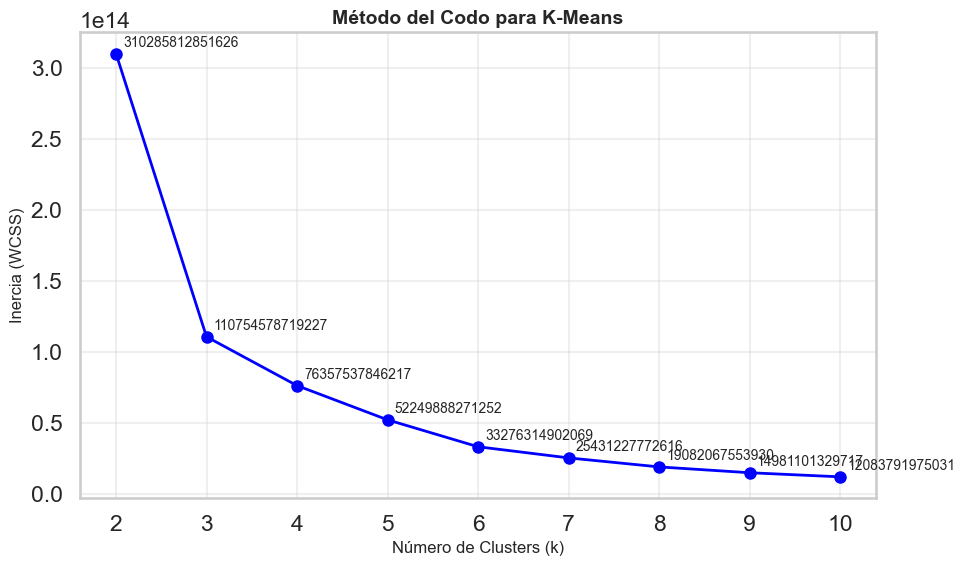

Análisis del Método del Codo:
    k       inertia     reduction
0   2  3.102858e+14  0.000000e+00
1   3  1.107546e+14  1.995312e+14
2   4  7.635754e+13  3.439704e+13
3   5  5.224989e+13  2.410765e+13
4   6  3.327631e+13  1.897357e+13
5   7  2.543123e+13  7.845087e+12
6   8  1.908207e+13  6.349160e+12
7   9  1.498110e+13  4.100966e+12
8  10  1.208379e+13  2.897309e+12


In [1042]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# Método del codo
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_all)
    inertias.append(kmeans.inertia_)

# Gráfico del codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.title('Método del Codo para K-Means', fontsize=14, fontweight='bold')
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inercia (WCSS)', fontsize=12)
plt.grid(True, alpha=0.3)

# Añadir valores en cada punto
for i, inertia in enumerate(inertias):
    plt.annotate(f'{inertia:.0f}', 
                xy=(K_range[i], inertia), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=10)

plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
elbow_results = pd.DataFrame({
    'k': K_range,
    'inertia': inertias,
    'reduction': [0] + [inertias[i-1] - inertias[i] for i in range(1, len(inertias))]
})

print("Análisis del Método del Codo:")
print(elbow_results.round(2))

In [1043]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Clustering
kmeans_no_scale = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels_no_scale = kmeans_no_scale.fit_predict(X_all)

# Reducción dimensional para visualizar (PCA)
pca = PCA(n_components=2, random_state=42)
X_pca_no_scale = pca.fit_transform(X_all)

# Crear dataframe para plotly
df_plot_no_scale = pd.DataFrame({
    'PC1': X_pca_no_scale[:, 0],
    'PC2': X_pca_no_scale[:, 1],
    'Cluster': labels_no_scale.astype(str),
    'Monetary': X_all['monetary'].values,
    'Frequency': X_all['frequency'].values,
    'Recency': X_all['recency_dias'].values
})

# Plot
fig1 = px.scatter(
    df_plot_no_scale,
    x='PC1', y='PC2',
    color='Cluster',
    hover_data=['Monetary', 'Frequency', 'Recency'],
    title=f'+Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}',
    width=800, height=600
)
fig1.show()

c:\Users\Dell\anaconda3\envs\demo\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [1044]:
pd.DataFrame(labels_no_scale).value_counts()

0
0    1226
1     250
2      55
Name: count, dtype: int64

In [1077]:
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler()
# scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_all)
X_train = pd.DataFrame(X_scaled, columns=X_all.columns)

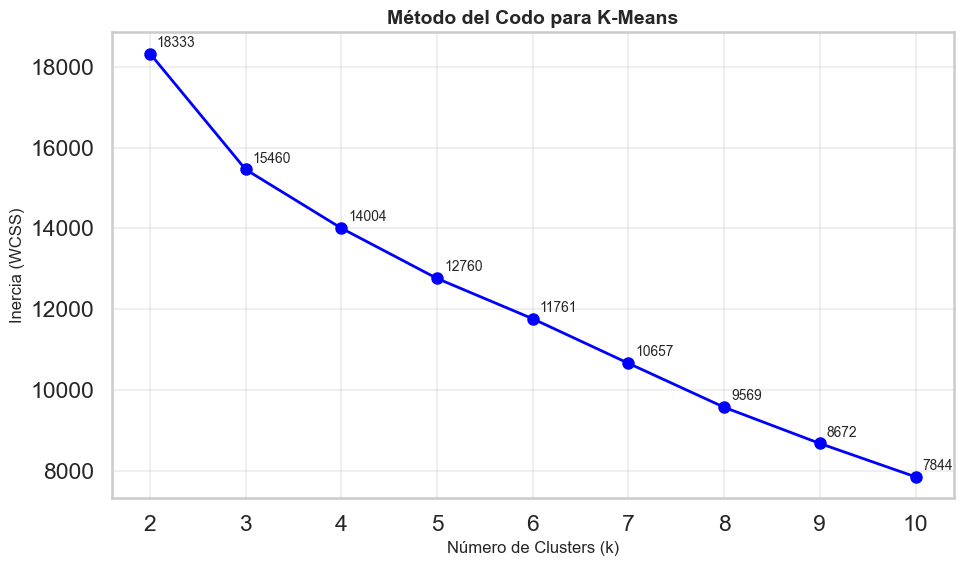

Análisis del Método del Codo:
    k   inertia  reduction
0   2  18333.16       0.00
1   3  15459.90    2873.27
2   4  14004.46    1455.43
3   5  12759.83    1244.64
4   6  11760.97     998.86
5   7  10657.35    1103.62
6   8   9568.56    1088.79
7   9   8671.56     897.00
8  10   7844.19     827.37


In [1078]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# Método del codo
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)

# Gráfico del codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.title('Método del Codo para K-Means', fontsize=14, fontweight='bold')
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inercia (WCSS)', fontsize=12)
plt.grid(True, alpha=0.3)

# Añadir valores en cada punto
for i, inertia in enumerate(inertias):
    plt.annotate(f'{inertia:.0f}', 
                xy=(K_range[i], inertia), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=10)

plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
elbow_results = pd.DataFrame({
    'k': K_range,
    'inertia': inertias,
    'reduction': [0] + [inertias[i-1] - inertias[i] for i in range(1, len(inertias))]
})

print("Análisis del Método del Codo:")
print(elbow_results.round(2))

In [1080]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

results = []

for k in range(3, 10):
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_km = kmeans.fit_predict(X_train)
    
    # Hierarchical
    hier = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels_hier = hier.fit_predict(X_train)
    
    # Métricas
    for name, labels in [('kmeans', labels_km), ('hierarchical', labels_hier)]:
        results.append({
            'method': name,
            'k': k,
            'silhouette': silhouette_score(X_train, labels),
            'calinski': calinski_harabasz_score(X_train, labels),
            'davies': davies_bouldin_score(X_train, labels)
        })

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

      method  k  silhouette   calinski   davies
      kmeans  3    0.360906 370.888604 1.731124
hierarchical  3    0.364349 361.869167 1.863596
      kmeans  4    0.381445 325.675719 1.727930
hierarchical  4    0.381629 318.469607 1.808331
      kmeans  5    0.398862 305.119638 1.775709
hierarchical  5    0.395595 294.664971 1.838255
      kmeans  6    0.404836 290.556853 1.420975
hierarchical  6    0.405384 285.669242 1.639203
      kmeans  7    0.309217 293.332356 1.558086
hierarchical  7    0.414747 284.959181 1.494415
      kmeans  8    0.319409 304.610357 1.383289
hierarchical  8    0.309173 289.388759 1.549172
      kmeans  9    0.325808 313.591489 1.134966
hierarchical  9    0.316786 299.070356 1.376191


In [1081]:
# Clustering
X_all = X_all.drop('cluster', axis=1, errors='ignore')
kmeans_scaled = KMeans(n_clusters=6, random_state=42, n_init='auto')
labels_scaled = kmeans_scaled.fit_predict(X_train)

# PCA
pca2 = PCA(n_components=2, random_state=42)
X_pca_scaled = pca2.fit_transform(X_train)

X_all['cluster'] = labels_scaled

# Dataframe
df_plot_scaled = pd.DataFrame({
    'PC1': X_pca_scaled[:, 0],
    'PC2': X_pca_scaled[:, 1],
    'Cluster': labels_scaled.astype(str),
    'Monetary': X_all['monetary'].values,
    'Frequency': X_all['frequency'].values,
    'Recency': X_all['recency_dias'].values,
    'pct_despensa': X_all['pct_despensa'].values,
    'pct_bebidas_alcoh': X_all['pct_bebidas_alcohólicas'].values
})

# Plot
fig2 = px.scatter(
    df_plot_scaled,
    x='PC1', y='PC2',
    color='Cluster',
    hover_data=['Monetary', 'Frequency', 'pct_despensa', 'pct_bebidas_alcoh'],
    title=f'Varianza explicada: {pca2.explained_variance_ratio_.sum():.2%}',
    width=800, height=600
)
fig2.show()

c:\Users\Dell\anaconda3\envs\demo\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [1082]:
X_all.groupby('cluster').mean().round(2)

,recency_dias,frequency,monetary,pct_bebidas,pct_bebidas_alcohólicas,pct_congelados,pct_despensa,pct_limpieza_cuidado,pct_lácteos_panadería,pct_snacks_golosinas,diversidad_categorias,productos_unicos,productos_por_transaccion,dias_entre_compras
cluster,,,,,,,,,,,,,,
0,338.73,1.05,6792.60,3.99,14.21,3.25,32.28,9.23,34.31,2.73,0.45,2.45,2.37,0.13
1,1.67,508.57,3568844.28,8.98,10.73,4.50,28.53,10.77,23.66,12.82,1.79,88.69,2.49,0.64
2,235.50,1.21,7717.96,1.74,0.88,1.95,14.47,1.40,5.32,74.23,0.54,2.71,2.41,1.28
3,27.93,14.21,101249.40,9.05,12.09,4.56,27.13,10.31,24.91,11.95,1.58,21.11,2.50,28.11
4,10.19,43.05,289119.79,9.89,10.18,4.61,28.35,10.90,23.19,12.88,1.67,37.11,2.47,7.18
5,2.29,210.25,1445478.62,9.04,10.73,4.35,28.60,10.42,23.80,13.05,1.78,72.58,2.47,1.81


In [ ]:
X_all.groupby('cluster')['cluster'].count()

cluster
0    175
1     58
2     28
3    321
4    718
5    231
Name: cluster, dtype: int64